# Pangeo Transformed Eulerian Mean Workload

This is a notebook for exploring the example in https://github.com/pangeo-data/distributed-array-examples/issues/3.

See also https://github.com/dcherian/ncar-challenge-suite/blob/main/tem.ipynb for the original, and the Cubed tracking issue at https://github.com/tomwhite/cubed/issues/145

In [1]:
import cubed
import cubed.random
from cubed.extensions.rich import RichProgressBar
import pandas as pd
import xarray as xr

Initialization parameters for the workload

In [2]:
dims = ("time", "level", "lat", "lon")
# nyears is number of years, adjust to make bigger, 
# full dataset is 60-ish years.
nyears = 1
#shape = (nyears * 365 * 24, 37, 721, 1440)
shape = (nyears * 31 * 24, 37, 72, 144)  # make smaller while exploring locally
chunks = (24, 1, -1, -1)
spec = cubed.Spec(allowed_mem="2GB")

Create random data stored in Zarr.

In [3]:
u = cubed.random.random(shape, chunks=chunks, spec=spec)
v = cubed.random.random(shape, chunks=chunks, spec=spec)
w = cubed.random.random(shape, chunks=chunks, spec=spec)
t = cubed.random.random(shape, chunks=chunks, spec=spec)
arrays = [u, v, w, t]
paths = [
    f"{spec.work_dir}/u_{nyears}.zarr",
    f"{spec.work_dir}/v_{nyears}.zarr",
    f"{spec.work_dir}/w_{nyears}.zarr",
    f"{spec.work_dir}/t_{nyears}.zarr",
]

In [4]:
# Comment in below to save then load Zarr from filesystem
# cubed.store(arrays, paths, compute_arrays_in_parallel=True, callbacks=[RichProgressBar()])

In [5]:
# u = cubed.from_zarr(paths[0], spec=spec)
# v = cubed.from_zarr(paths[1], spec=spec)
# w = cubed.from_zarr(paths[2], spec=spec)
# t = cubed.from_zarr(paths[3], spec=spec)

In [6]:
ds = xr.Dataset(
    {
        "U": (dims, u),
        "V": (dims, v),
        "W": (dims, w),
        "T": (dims, t),
    },
    coords={"time": pd.date_range("2001-01-01", periods=shape[0], freq="H")},
)
ds

,Array,Chunk
Bytes,2.3 GB,2.0 MB
Shape,"(744, 37, 72, 144)","(24, 1, 72, 144)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk
Bytes,2.3 GB,2.0 MB
Shape,"(744, 37, 72, 144)","(24, 1, 72, 144)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk


In [7]:
# Note: we actually want skipna=True, but this isn't implemented in xarray yet
# see https://github.com/pydata/xarray/issues/7243
zonal_means = ds.mean("lon", skipna=False)
zonal_means

,Array,Chunk
Bytes,15.9 MB,13.8 KB
Shape,"(744, 37, 72)","(24, 1, 72)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk
Bytes,15.9 MB,13.8 KB
Shape,"(744, 37, 72)","(24, 1, 72)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk


In [8]:
anomaly = ds - zonal_means
anomaly['uv'] = anomaly.U*anomaly.V
anomaly['vt'] = anomaly.V*anomaly.T
anomaly['uw'] = anomaly.U*anomaly.W
anomaly

,Array,Chunk
Bytes,2.3 GB,2.0 MB
Shape,"(744, 37, 72, 144)","(24, 1, 72, 144)"
Count,6 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk
Bytes,2.3 GB,2.0 MB
Shape,"(744, 37, 72, 144)","(24, 1, 72, 144)"
Count,6 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk


In [9]:
temdiags = zonal_means.merge(anomaly[['uv','vt','uw']].mean("lon", skipna=False))  # actually want skipna=True
temdiags

,Array,Chunk
Bytes,15.9 MB,13.8 KB
Shape,"(744, 37, 72)","(24, 1, 72)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk
Bytes,15.9 MB,13.8 KB
Shape,"(744, 37, 72)","(24, 1, 72)"
Count,3 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk


In [10]:
# note method="blockwise" uses flox
temdiags = temdiags.resample(time="D").mean(method="blockwise", skipna=False)  # actually want skipna=True
temdiags

,Array,Chunk
Bytes,660.7 KB,576 bytes
Shape,"(31, 37, 72)","(1, 1, 72)"
Count,6 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk
Bytes,660.7 KB,576 bytes
Shape,"(31, 37, 72)","(1, 1, 72)"
Count,6 arrays in Plan,1147 Chunks
Type,float64,np.ndarray
,Array,Chunk


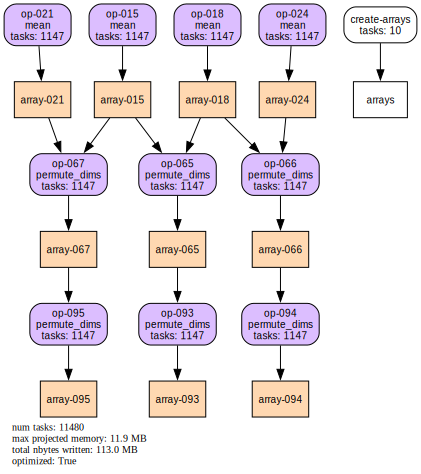

In [11]:
cubed.visualize(
    *(temdiags[var].data for var in ("uv", "vt", "uw")),
)

In [12]:
temdiags.compute(callbacks=[RichProgressBar()])

Output()

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 31, level: 37, lat: 72)
Coordinates:
  * time     (time) datetime64[ns] 248B 2001-01-01 2001-01-02 ... 2001-01-31
Dimensions without coordinates: level, lat
Data variables:
    U        (time, level, lat) float64 661kB 0.502 0.5039 0.504 ... 0.5 0.4956
    V        (time, level, lat) float64 661kB 0.4953 0.4931 ... 0.4944 0.4976
    W        (time, level, lat) float64 661kB 0.5017 0.4984 ... 0.5083 0.5015
    T        (time, level, lat) float64 661kB 0.4949 0.503 ... 0.5024 0.487
    uv       (time, level, lat) float64 661kB 0.00129 0.0009764 ... 0.0003541
    vt       (time, level, lat) float64 661kB -0.002118 -0.001934 ... 0.001608
    uw       (time, level, lat) float64 661kB 0.0007928 -0.00245 ... -0.002159